# Coronavirus (COVID-19) England Map
## David Beavan @DavidBeavan
## Licence: MIT. Sources: see below
## 👇 Scroll down for maps and tables 👇
## Notes
* This does what other maps do not, it shows cases per population
* England only at the moment (I would like to merge Scotland, Wales and NI)
* UK dataset https://www.gov.uk/government/publications/covid-19-track-coronavirus-cases 'UTLA cases table'
* Maps reported cases and those with location
* The dataset above may not always be up to date
* Population estimates are from ONS, mid-2018
* I am not distributing any data, but it will be fetched
* The government has been actively updating the data made available, this might break this tool

In [1]:
# load libraries
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import requests
import shutil
import io
import zipfile
import datetime
from PIL import Image
%matplotlib inline

In [2]:
# Prep data
# Data is not packaged with code, Will download from sources and save for future runs


def prep_data():
    data_base_dir = Path('data/primary_sources')
    data_base_dir.mkdir(parents=True, exist_ok=True)

    try:
        # https://geoportal.statistics.gov.uk/datasets/counties-and-unitary-authorities-december-2019-boundaries-uk-bgc
        # This file contains the digital vector boundaries for Counties and Unitary Authorities in the United Kingdom, as at December 2019
        # Office for National Statistics licensed under the Open Government Licence v.3.0
        # Contains OS data © Crown copyright and database right 2019

        data_sub_dir = data_base_dir.joinpath('utla_boundaries')

        if not data_sub_dir.is_dir():
            r = requests.get(
                'https://opendata.arcgis.com/datasets/29827d4c079349888acd7db3f84e3449_0.zip?outSR=%7B%22latestWkid%22%3A27700%2C%22wkid%22%3A27700%7D')

            data_sub_dir.mkdir(parents=True)

            myzipfile = zipfile.ZipFile(io.BytesIO(r.content))
            myzipfile.extractall(data_sub_dir)
    except:
        print('Error: Could not fetch utla_boundaries')

    try:
        # https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/populationestimatesforukenglandandwalesscotlandandnorthernireland
        # Estimates of the population for the UK, England and Wales, Scotland and Northern Ireland as at mid-2018
        # Office for National Statistics licensed under the Open Government Licence
        # Crown copyright 2019

        data_sub_dir = data_base_dir.joinpath('population_estimates')

        if not data_sub_dir.is_dir():
            r = requests.get('https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationestimates%2fdatasets%2fpopulationestimatesforukenglandandwalesscotlandandnorthernireland%2fmid20182019laboundaries/ukmidyearestimates20182019ladcodes.xls')

            data_sub_dir.mkdir(parents=True)

            file = open(data_sub_dir.joinpath(
                'ukmidyearestimates20182019ladcodes.xls'), 'wb')
            file.write(r.content)
            file.close()
    except:
        print('Error: Could not fetch population_estimates')

    try:
        # https://www.arcgis.com/home/item.html?id=b684319181f94875a6879bbc833ca3a6
        # Data is based on cases reported to PHE and matched to ONS administrative geography codes and names to generate geographic case counts.
        # Contains Ordnance Survey data © Crown copyright and database right 2020.  Contains National Statistics data © Crown copyright and database right 2020

        data_sub_dir = data_base_dir.joinpath('countyuas_cases')

        if not data_sub_dir.is_dir():
            r = requests.get(
                'https://www.arcgis.com/sharing/rest/content/items/b684319181f94875a6879bbc833ca3a6/data')

            data_sub_dir.mkdir(parents=True)

            file = open(data_sub_dir.joinpath('countyuas_cases.csv'), 'wb')
            file.write(r.content)
            file.close()
    except:
        print('Error: Could not fetch covid cases')


prep_data()

# Maps

In [3]:
# Load Upper Tier Local Authority (UTLA) AKA Counties and unitary Authorities boundary shapefile
utla_df = gpd.read_file(Path(
    "data/primary_sources/utla_boundaries/Counties_and_Unitary_Authorities_December_2019_Boundaries_UK_BGC.shp"))

# Remove Scotland and NI (for now, this is only parsing England data)
utla_df = utla_df[~utla_df['ctyua19cd'].str.contains('^[SN]')]

# Remove Wales (for now, this is only parsing England data)
utla_df = utla_df[utla_df['ctyua19nmw'].isnull()]

# Drop unused columns
utla_df.drop(columns=['objectid', 'ctyua19nmw', 'bng_e',
                      'bng_n', 'long', 'lat', 'st_lengths'], inplace=True)

# Index on ctyua19cd AKA region code
utla_df.set_index('ctyua19cd', inplace=True)

In [4]:
# Preview data
# utla_df.head()

In [5]:
# Preview map

# ax = utla_df.plot()
# ax.axis('off')

In [6]:
# Preview London map

# ax = utla_df.plot()
# ax.set_xlim([500000, 560000])
# ax.set_ylim([150000, 210000])
# ax.axis('off')

In [7]:
# Load population estimates mid-2018
pop_df = pd.read_excel(Path("data/primary_sources/population_estimates/ukmidyearestimates20182019ladcodes.xls"),
                       header=4, sheet_name='MYE3', usecols='A:O')

# Drop unused columns
pop_df.drop(columns=['Name', 'Geography1', 'Estimated Population  mid-2017', 'Births', 'Deaths', 'Births minus Deaths', 'Internal Migration Inflow', 'Internal Migration Outflow',
                     'Internal Migration Net', 'International Migration Inflow', 'International Migration Outflow', 'International Migration Net', 'Other'], inplace=True)

# Rename population column
pop_df.rename(
    columns={'Estimated Population  mid-2018': 'population'}, inplace=True)

# Index on Code AKA region code
pop_df.set_index('Code', inplace=True)

In [8]:
# Preview data
# pop_df.head()

In [9]:
# Check all regions in utla have population estimates

if len(list(set(utla_df.index).difference(pop_df.index))) != 0:
    print('Error: Not all regions have population data')

# There will be regions from the population estimates that do not have an entry in utla.
# The population data has larger areas than utlas, e.g. nations, it also has Scotland, NI and Wales

In [10]:
# Join the population estimates to the utla regions
utla_pop_df = utla_df.join(pop_df)

In [11]:
# The England covid-19 data merges Hackney and City of London, and Cornwall and Isles of Scilly, we must do the same


def merge_areas(df, area1, area2, new_index, new_title):
    # Get first area info, and delete it
    area1_rows = df.loc[df['ctyua19nm'] == area1]
    if len(area1_rows) != 1:
        print('Error: Cannot find entry')
    area1_row = area1_rows.iloc[0]
    df = df[df['ctyua19nm'] != area1]

    # Get second area info, and delete it
    area2_rows = df.loc[df['ctyua19nm'] == area2]
    if len(area2_rows) != 1:
        print('Error: Cannot find entry')
    area2_row = area2_rows.iloc[0]
    df = df[df['ctyua19nm'] != area2]

    # Merge areas and insert new combigned area
    new_shape = area1_row['geometry'].union(area2_row['geometry'])
    new_row = [new_title, area1_row['st_areasha'] + area2_row['st_areasha'],
               new_shape, area1_row['population'] + area2_row['population']]
    df.loc[new_index] = new_row

    return df


# merge areas, give them the index code (e.g. E09000012) used by the Government covid cases dataset
utla_pop_df = merge_areas(utla_pop_df, 'Hackney', 'City of London',
                          'E09000012', 'Hackney and City of London')
utla_pop_df = merge_areas(utla_pop_df, 'Cornwall', 'Isles of Scilly',
                          'E06000052', 'Cornwall and Isles of Scilly')

In [12]:
# Preview data
# utla_pop_df.head()

In [13]:
def show_map(df, variable, title, size, cmap, limits=None, save_filename=None):

    # Prep plot
    fig, ax = plt.subplots(1, figsize=size, facecolor='LightGray')

    # Zoom in to limits, if given
    if limits:
        ax.set_xlim(limits[0])
        ax.set_ylim(limits[1])

    # Plot map
    df.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='gray')

    # Remove the axis
    ax.axis('off')

    # Add title
    ax.set_title(title, fontdict={
                 'fontsize': 'xx-large', 'fontweight': 'bold'})

    # Add attributions
    ax.annotate('Code: David Beavan Twitter:@DavidBeavan GitHub:https://github.com/DavidBeavan/coronavirus_covid-19\nPopulation estimates mid-2018\nSource: Office for National Statistics licensed under the Open Government Licence\nContains OS data © Crown copyright and database right 2019',
                xy=(0.02, .08), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize='medium', color='black')

    # Add legend
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=0, vmax=variable.max()))
    sm._A = []
    cbar = fig.colorbar(sm)

    # Save map
    if save_filename is not None:
        fig.savefig(save_filename, dpi=100)

In [14]:
# Population map
# show_map(utla_pop_df, utla_pop_df['population'] / 1000,
#          'Population (raw) (1,000s)', (12, 12), 'Greys')

In [15]:
# Population map London
# show_map(utla_pop_df, utla_pop_df['population'] / 1000, 'Population (raw) London (1,000s)',
#          (12, 12), 'Greys', ([500000, 560000], [150000, 210000]))

In [16]:
# Population density map
# show_map(utla_pop_df, (utla_pop_df['population'] / 1000) / (utla_pop_df['st_areasha'] /
#                                                             1000000), 'Population (density) (1,000s per km2)', (12, 12), 'Greens')

In [17]:
# Population density map London
# show_map(utla_pop_df, (utla_pop_df['population'] / 1000) / (utla_pop_df['st_areasha'] / 1000000),
#          'Population (density) London (1,000s per km2)', (12, 12), 'Greens', ([500000, 560000], [150000, 210000]))

In [18]:
# Load population estimates mid-2018
countyuas_cases_df = pd.read_csv(
    Path("data/primary_sources/countyuas_cases/countyuas_cases.csv"))

# Drop unneeded columns
countyuas_cases_df.drop(columns=['GSS_NM'], inplace=True)

# Index on GSS_CD AKA region code
countyuas_cases_df.set_index('GSS_CD', inplace=True)

In [19]:
# Preview data
# countyuas_cases_df.head()

In [20]:
# Check all regions in utla have covid case data

if len(list(set(utla_pop_df.index).difference(countyuas_cases_df.index))) != 0:
    print('Error: Not all regions have covid case data')

# Check all regions in covid case data have utla area
if len(list(set(countyuas_cases_df.index).difference(utla_pop_df.index))) != 0:
    print('Error: Not all regions have covid case data')

In [21]:
# Join the covid cases to utla regions
utla_pop_cases_df = utla_pop_df.join(countyuas_cases_df)

# Add new column to summerise total cases per 1,000 ppl
utla_pop_cases_df['cases_per_1000'] = (
    utla_pop_cases_df['TotalCases'] / (utla_pop_cases_df['population'] / 1000))

In [22]:
# Preview data
# utla_pop_cases_df.head()

In [23]:
today_date = datetime.date.today().isoformat()

date_fetched = '\nData fetched ' + today_date + \
    ' may be delayed'

In [24]:
# Set maps output directoru
maps_output_dir = Path('outputs/maps')
maps_output_dir.mkdir(parents=True, exist_ok=True)

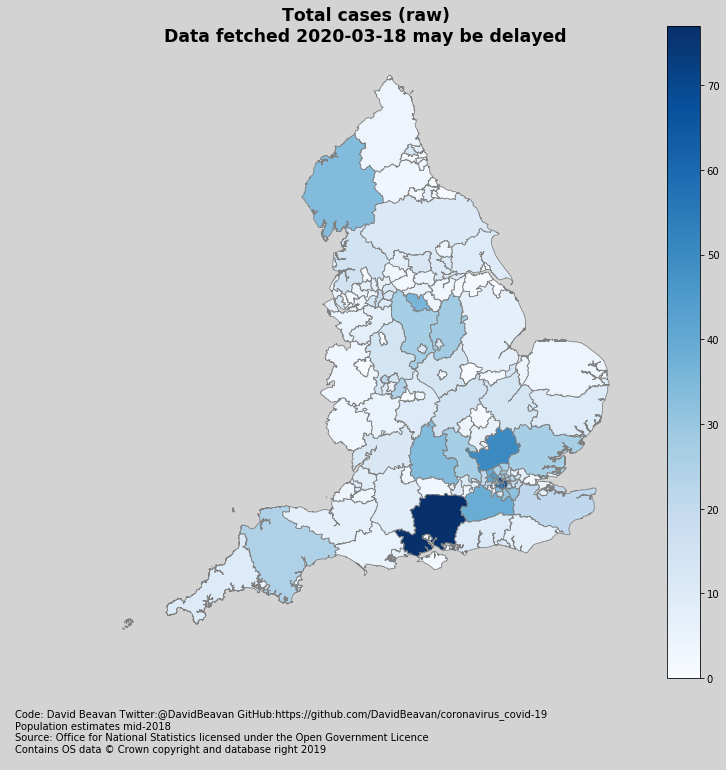

In [25]:
# Cases map
show_map(utla_pop_cases_df, utla_pop_cases_df['TotalCases'],
         'Total cases (raw)' + date_fetched, (12, 12), 'Blues', save_filename=maps_output_dir.joinpath('coronavirus_covid-19_england_map_raw_' + today_date + '.png'))

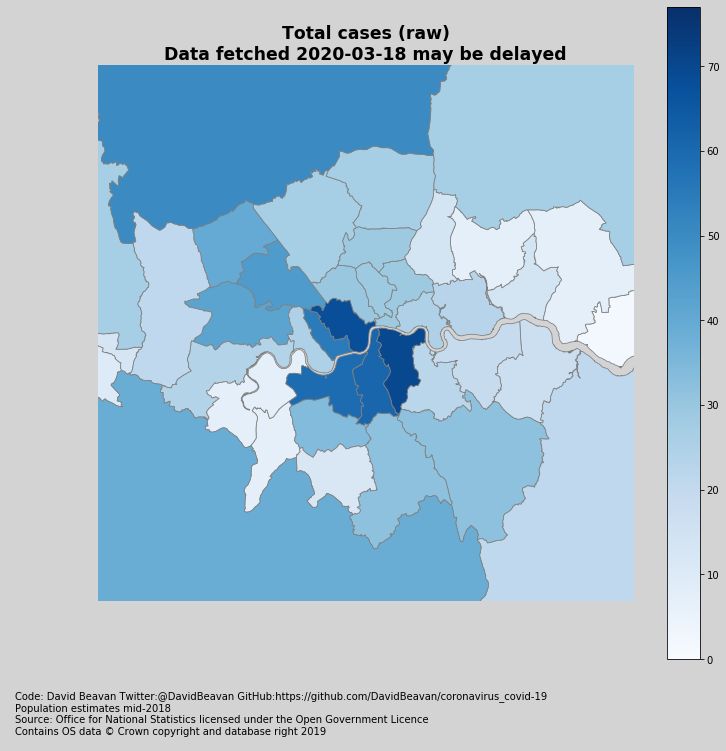

In [26]:
# Cases map London
show_map(utla_pop_cases_df, utla_pop_cases_df['TotalCases'], 'Total cases (raw)' +
         date_fetched, (12, 12), 'Blues', ([500000, 560000], [150000, 210000]), save_filename=maps_output_dir.joinpath('coronavirus_covid-19_london_map_raw_' + today_date + '.png'))

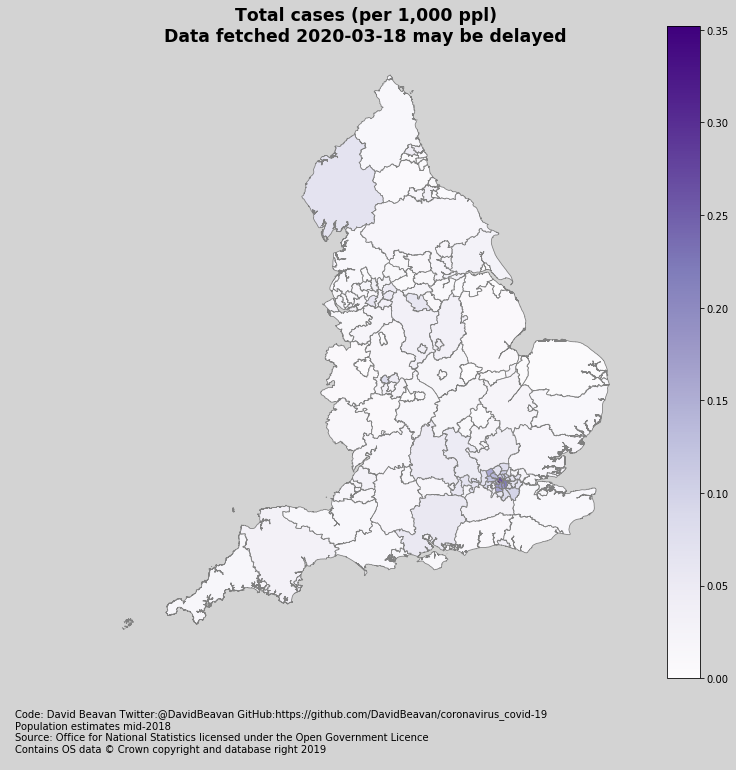

In [27]:
# Cases map per 1,000 ppl
show_map(utla_pop_cases_df, utla_pop_cases_df['cases_per_1000'],
         'Total cases (per 1,000 ppl)' + date_fetched, (12, 12), 'Purples', save_filename=maps_output_dir.joinpath('coronavirus_covid-19_england_map_normalised_' + today_date + '.png'))

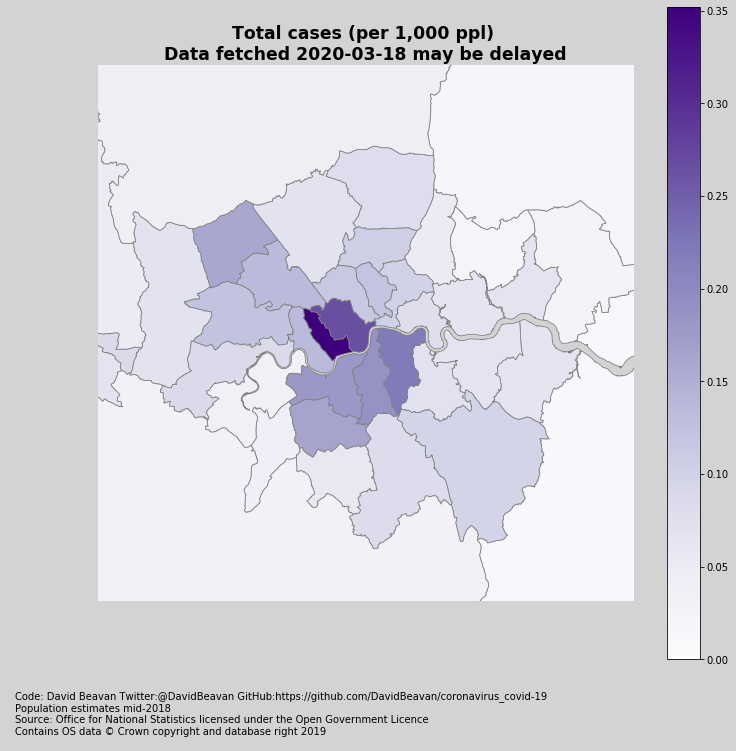

In [28]:
# Cases map per 1,000 ppl London
show_map(utla_pop_cases_df, utla_pop_cases_df['cases_per_1000'], 'Total cases (per 1,000 ppl) ' +
         date_fetched, (12, 12), 'Purples', ([500000, 560000], [150000, 210000]), save_filename=maps_output_dir.joinpath('coronavirus_covid-19_london_map_normalised_' + today_date + '.png'))

# Tables

In [29]:
# Number of cases (where location is known)
# 2020-3-12 = 434
# 2020-3-13 = 535
# 2020-3-14 = 764
# 2020-3-15 = 975
# 2020-3-15 = 1109
utla_pop_cases_df['TotalCases'].sum()

2065

In [30]:
# Top cases (raw)
utla_pop_cases_df.sort_values(['TotalCases', 'ctyua19nm'], ascending=[False, True])[
    ['ctyua19nm', 'population', 'TotalCases']].head(10)

,ctyua19nm,population,TotalCases
E10000014,Hampshire,1376316.0,77
E09000028,Southwark,317256.0,70
E09000033,Westminster,255324.0,68
E09000022,Lambeth,325917.0,61
E09000032,Wandsworth,326474.0,59
E09000020,Kensington and Chelsea,156197.0,55
E10000015,Hertfordshire,1184365.0,50
E09000005,Brent,330795.0,45
E09000009,Ealing,341982.0,42
E09000015,Harrow,250149.0,40


In [31]:
# Bottom cases (raw)
utla_pop_cases_df.sort_values(['TotalCases', 'ctyua19nm'], ascending=[False, True])[
    ['ctyua19nm', 'population', 'TotalCases']].tail(10)

,ctyua19nm,population,TotalCases
E06000010,"Kingston upon Hull, City of",260645.0,1
E08000011,Knowsley,149571.0,1
E06000013,North Lincolnshire,172005.0,1
E06000003,Redcar and Cleveland,136718.0,1
E08000029,Solihull,214909.0,1
E06000021,Stoke-on-Trent,255833.0,1
E06000002,Middlesbrough,140545.0,0
E06000012,North East Lincolnshire,159821.0,0
E06000017,Rutland,39697.0,0
E06000020,Telford and Wrekin,177799.0,0


In [32]:
# Top cases (per 1,000 ppl)
utla_pop_cases_df.sort_values(['cases_per_1000', 'ctyua19nm'], ascending=[False, True])[
    ['ctyua19nm', 'population', 'cases_per_1000']].head(10)

,ctyua19nm,population,cases_per_1000
E09000020,Kensington and Chelsea,156197.0,0.352119
E09000033,Westminster,255324.0,0.266328
E09000028,Southwark,317256.0,0.220642
E09000022,Lambeth,325917.0,0.187164
E09000032,Wandsworth,326474.0,0.180719
E09000024,Merton,206186.0,0.164900
E09000015,Harrow,250149.0,0.159905
E09000005,Brent,330795.0,0.136036
E09000013,Hammersmith and Fulham,185426.0,0.134825
E09000009,Ealing,341982.0,0.122813


In [33]:
# Bottom cases (per 1,000 ppl)
utla_pop_cases_df.sort_values(['cases_per_1000', 'ctyua19nm'], ascending=[False, True])[
    ['ctyua19nm', 'population', 'cases_per_1000']].tail(10)

,ctyua19nm,population,cases_per_1000
E08000037,Gateshead,202508.0,0.004938
E08000029,Solihull,214909.0,0.004653
E08000034,Kirklees,438727.0,0.004559
E10000020,Norfolk,903680.0,0.004426
E06000021,Stoke-on-Trent,255833.0,0.003909
E06000010,"Kingston upon Hull, City of",260645.0,0.003837
E06000002,Middlesbrough,140545.0,0.000000
E06000012,North East Lincolnshire,159821.0,0.000000
E06000017,Rutland,39697.0,0.000000
E06000020,Telford and Wrekin,177799.0,0.000000


# Animated maps

In [34]:
# Load time series case dataset
# As fetched and saved by the scraper
# coronavirus_covid-19_england_cases_scraper.ipynb
utla_cases_time_series_df = pd.read_csv(Path(
    'data/secondary_sources/utla_cases_table/utla_cases.csv'), index_col='utla')

# Drop unneeded columns
utla_cases_time_series_df.drop(columns=['GSS_NM'], inplace=True)

# Set maps output directoru
maps_output_dir = Path('outputs/maps')

In [35]:
# Preview data
# utla_cases_time_series_df

In [36]:
# Join the time series case dataset to utla population
utla_pop_time_series_df = utla_pop_df.join(utla_cases_time_series_df)

In [37]:
# Preview data
# utla_pop_time_series_df.head()

In [38]:
# To normalise the counts, we need to know the maximum value for any area across all time

date_cols = utla_pop_time_series_df.iloc[:, 4:]
# date_cols

case_count_max = date_cols.values.max()
# print(case_count_max)

max_date = date_cols.columns[-1]
# max_date

# Add new columns to summerise total cases per 1,000 ppl
for date in date_cols:
    utla_pop_time_series_df[date + '_per_1000'] = (
        utla_pop_time_series_df[date] / (utla_pop_time_series_df['population'] / 1000))

date_cols_normalised = utla_pop_time_series_df.iloc[:, 4 + len(date_cols.columns):]
# date_cols_normalised

case_count_max_normalised = date_cols_normalised.values.max()
# print(case_count_max_normalised)

In [39]:
# Preview data
utla_pop_time_series_df.head()

,ctyua19nm,st_areasha,geometry,population,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,...,2020-03-09_per_1000,2020-03-10_per_1000,2020-03-11_per_1000,2020-03-12_per_1000,2020-03-13_per_1000,2020-03-14_per_1000,2020-03-15_per_1000,2020-03-16_per_1000,2020-03-17_per_1000,2020-03-18_per_1000
E06000001,Hartlepool,9.377035e+07,"POLYGON ((447097.001 537152.001, 447228.798 53...",93242.0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010725
E06000002,Middlesbrough,5.385812e+07,"MULTIPOLYGON (((449862.750 521262.400, 449853....",140545.0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
E06000003,Redcar and Cleveland,2.451404e+08,"MULTIPOLYGON (((455939.672 527395.073, 456154....",136718.0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.007314,0.007314,0.000000,0.007314,0.007314
E06000004,Stockton-on-Tees,2.049037e+08,"MULTIPOLYGON (((444126.099 528005.799, 444165....",197213.0,0,0,0,2,2,2,...,0.0,0.0,0.010141,0.010141,0.010141,0.010141,0.010141,0.010141,0.015212,0.030424
E06000005,Darlington,1.974858e+08,"POLYGON ((423475.701 524731.597, 423497.204 52...",106566.0,0,0,0,0,0,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.018768,0.018768,0.018768,0.009384,0.018768


In [40]:
def show_map_for_animation(df, variable, title, date, size, cmap, vmax, limits=None):

    # Prep plot
    fig, ax = plt.subplots(1, figsize=size, facecolor='LightGray')

    # Zoom in to limits, if given
    if limits:
        ax.set_xlim(limits[0])
        ax.set_ylim(limits[1])

    # Plot map
    df.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax,
            edgecolor='gray', norm=plt.Normalize(vmin=0, vmax=vmax))

    # Remove the axis
    ax.axis('off')

    # Add title
    ax.set_title(title + ' ' + date, fontdict={
                 'fontsize': 'xx-large', 'fontweight': 'bold'})

    # Add attributions
    ax.annotate('Code: David Beavan Twitter:@DavidBeavan GitHub:https://github.com/DavidBeavan/coronavirus_covid-19\nPopulation estimates mid-2018\nSource: Office for National Statistics licensed under the Open Government Licence\nContains OS data © Crown copyright and database right 2019',
                xy=(0.02, .08), xycoords='figure fraction',
                horizontalalignment='left', verticalalignment='top',
                fontsize='medium', color='black')

    # Add legend
    sm = plt.cm.ScalarMappable(
        cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm)

    # Return map without displaying
    buffer = io.BytesIO()
    fig.savefig(buffer, facecolor='LightGray')

    plt.close('all')

    return buffer

In [41]:
def animated_map(df, date_cols, title, size, cmap, vmax, save_as, limits=None):
    images = []

    for date in date_cols:
        buffer = show_map_for_animation(
            df, df[date], title, date, size, cmap, vmax, limits)

        frame = Image.open(buffer)
        images.append(frame)

    # Save the frames as an animated GIF
    images[0].save(save_as, save_all=True, append_images=images[1:], duration=1000,
                   loop=0, palette=Image.ADAPTIVE, include_color_table=True, interlace=False)
    
    return 

In [42]:
animated_map(utla_pop_time_series_df, date_cols,
             'Total cases (raw)', (12, 12), 'Blues', case_count_max, maps_output_dir.joinpath('coronavirus_covid-19_england_map_raw_animation_' + max_date + '.gif'))

animated_map(utla_pop_time_series_df, date_cols,
             'Total cases (raw)', (12, 12), 'Blues', case_count_max, maps_output_dir.joinpath('coronavirus_covid-19_london_map_raw_animation_' + max_date + '.gif'), ([500000, 560000], [150000, 210000]))

animated_map(utla_pop_time_series_df, date_cols_normalised,
             'Total cases (per 1,000 ppl)', (12, 12), 'Purples', case_count_max_normalised, maps_output_dir.joinpath('coronavirus_covid-19_england_map_normalised_animation_' + max_date + '.gif'))

animated_map(utla_pop_time_series_df, date_cols_normalised,
             'Total cases (per 1,000 ppl)', (12, 12), 'Purples', case_count_max_normalised, maps_output_dir.joinpath('coronavirus_covid-19_london_map_normalised_animation_' + max_date + '.gif'), ([500000, 560000], [150000, 210000]))

In [43]:
# Remove covid-19 case data, so fresh data is fetched

# Delete old backup
backup_dir = Path('data/primary_sources_bak/primary_sources_bak_' +
                  datetime.date.today().isoformat())
if backup_dir.exists():
    shutil.rmtree(backup_dir)

# Make new backup
shutil.copytree(Path('data/primary_sources'), backup_dir)

# Remove existing covid case data
if Path('data/primary_sources/countyuas_cases/countyuas_cases.csv').exists():
    Path('data/primary_sources/countyuas_cases/countyuas_cases.csv').unlink()
if Path('data/primary_sources/countyuas_cases').exists():
    Path('data/primary_sources/countyuas_cases').rmdir()